### Loading the dataset in a big dict

In this notebook we perform the conversion of the txt tokens to a 2D file containing for each song the sequence of ids of its tokens.
For a song to be added to the dataset, it needs to contain bass guitar and a rhythmic guitar.

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import guitarpro as pygp
import pathlib
import pickle
import matplotlib.pyplot as plt


In [ ]:
path_to_bass_folder = pathlib.Path(r"..\..\data\BGTG\BGTG_Bass")
thr_measures = 16
thr_max_tokens = 800
thr_min_tokens = 50

# Iterate over all the alphabetical and group folders within each folders 
# For the first implementation we will assume that if a song has bass it also has RG.

In [10]:
# Loop on the files of the bass folder, for each file check if there is a corresponding file in the RG folder
# Then generate the bass sequence and the RG sequence 
path_errors=0 # Count songs that have bass but no RG
token_errors=0 # Count songs that have too many or too few tokens
path_errors_list=[]
big_dict = {'All_Events':[], 'Encoder_RG':[], 'Decoder_Bass':[]}

# big_dict will have the following structure:
# keys: encoder_rg, decoder_bass
# big_dict['encoder_rg'][0] = list of rg txt tokens for the first song
# big_dict['decoder_bass'][0] = list of bass txt tokens for the first song

for bass_file_path in tqdm(path_to_bass_folder.rglob("*.txt"), total=14480, desc="Generating sequences of tokens"):
    # Replace _bass with _rythmic and BGTG_Bass by BGTG_RG to get the corresponding RG file
    rg_file_path = pathlib.Path((str(bass_file_path).replace("_bass.txt", "_rythmic.txt")).replace("BGTG_Bass", "BGTG_RG"))
    all_file_path = pathlib.Path((str(bass_file_path).replace("_bass.txt", "_rythmic.txt")).replace("BGTG_Bass", "BGTG_RG_Bass"))

    song_name = bass_file_path.stem.split("_")[0]
    
    if rg_file_path.exists() and all_file_path.exists():
        bass_sequence = []
        rg_sequence = []
        all_events_sequence = []
        remove_song = False
        # Truncate the token sequences at a certain number of measures
        # Remove the token sequences that have too much tokens
        
        # Open the bass file
        with open(bass_file_path, 'r') as bass_file:
            bass_lines = bass_file.readlines()
            count_measures = 0
            bass_token_count = 0
            for line in bass_lines:
                bass_token_count+=1
                if line.strip() == "new_measure":
                    count_measures+=1
                    if count_measures == thr_measures:
                        break
                    
                bass_sequence.append(line.strip())
                
            if bass_token_count >= thr_max_tokens or bass_token_count <= thr_min_tokens:
                # print("Song removed, too many or too few bass tokens", song_name, bass_token_count)
                remove_song = True
                token_errors+=1
                
        if remove_song:
            continue
        
        with open(rg_file_path, 'r') as rg_file:
            rg_lines = rg_file.readlines()
            count_measures = 0
            rg_token_count = 0
            for line in rg_lines:
                rg_token_count+=1
                if line.strip() == "new_measure":
                    count_measures+=1
                    if count_measures == thr_measures:
                        break
            
                rg_sequence.append(line.strip())
                
            if rg_token_count >= thr_max_tokens or rg_token_count <= thr_min_tokens:
                # print("Song removed, too many or too few RG tokens", song_name, rg_token_count)
                remove_song = True
                token_errors+=1
                
        if remove_song:
            continue
                
        with open(all_file_path, 'r') as all_file:
            all_lines = all_file.readlines()
            count_measures = 0
            for line in all_lines:
                if line.strip() == "new_measure":
                    count_measures+=1
                    if count_measures == thr_measures:
                        break

                all_events_sequence.append(line.strip())
        
        if not remove_song:
            big_dict['Encoder_RG'].append(rg_sequence)
            big_dict['Decoder_Bass'].append(bass_sequence)
            big_dict['All_Events'].append(all_events_sequence)
        
    else:
        path_errors+=1
        path_errors_list.append((song_name, bass_file_path, rg_file_path, all_file_path))

print("Path errors: ", path_errors, "Token errors: ", token_errors)

Generating sequences of tokens: 100%|██████████| 14480/14480 [00:53<00:00, 269.90it/s]

Path errors:  1480 Token errors:  1980


In [ ]:
# Dump the big_dict to a pickle file

with open(r"..\..\data\processed\preprocessed_dadagp_" + str(thr_measures) + '_' + str(thr_max_tokens) + '_' + str(thr_min_tokens) + ".pickle", "wb") as handle:
    pickle.dump(big_dict, handle, pickle.HIGHEST_PROTOCOL)

In [12]:
len(big_dict['Encoder_RG']), len(big_dict['Decoder_Bass']), len(big_dict['All_Events'])

(11020, 11020, 11020)

Max encoder length:  798
Max decoder length:  792
Min encoder length:  50
Min decoder length:  50
Average encoder length:  345.06696914700547
Average decoder length:  218.1606170598911
Median encoder length:  324.0
Median decoder length:  205.0


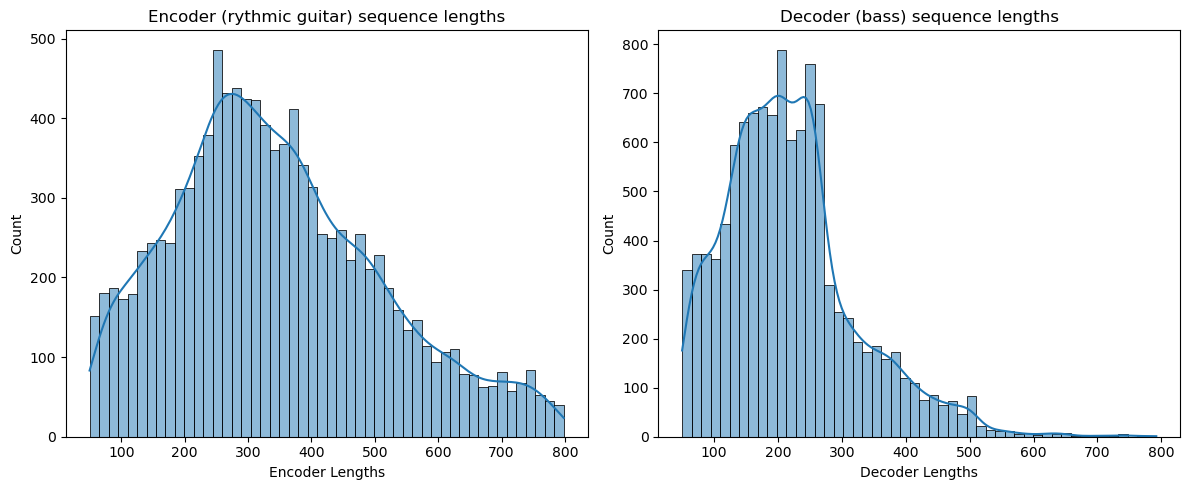

In [13]:
DEC_LENGTH = []
ENC_LENGTH = []

for k in range(0, len(big_dict['Encoder_RG'])):
    #get max, min and average length of the sequences
    DEC_LENGTH.append(len(big_dict['Decoder_Bass'][k]))
    ENC_LENGTH.append(len(big_dict['Encoder_RG'][k]))
    
max_enc_length = max(ENC_LENGTH)
max_dec_length = max(DEC_LENGTH)
min_enc_length = min(ENC_LENGTH)
min_dec_length = min(DEC_LENGTH)
avg_enc_length = np.mean(ENC_LENGTH)
avg_dec_length = np.mean(DEC_LENGTH)
med_enc_length = np.median(ENC_LENGTH)
med_dec_length = np.median(DEC_LENGTH)

print("Max encoder length: ", max_enc_length)
print("Max decoder length: ", max_dec_length)
print("Min encoder length: ", min_enc_length)
print("Min decoder length: ", min_dec_length)
print("Average encoder length: ", avg_enc_length)
print("Average decoder length: ", avg_dec_length)
print("Median encoder length: ", med_enc_length)
print("Median decoder length: ", med_dec_length)


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for visualization
df = pd.DataFrame({
    "Encoder Lengths": ENC_LENGTH,
    "Decoder Lengths": DEC_LENGTH
})

df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# Plot histogram for encoder sequence lengths
sns.histplot(df["Encoder Lengths"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Encoder (rythmic guitar) sequence lengths")

# Plot histogram for decoder sequence lengths
sns.histplot(df["Decoder Lengths"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Decoder (bass) sequence lengths")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("../../outputs/figs/sequence_lengths_" + str(thr_measures) + '_' + str(thr_max_tokens) + '_' + str(thr_min_tokens) + ".png")  # Save as PNG
plt.show()